In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

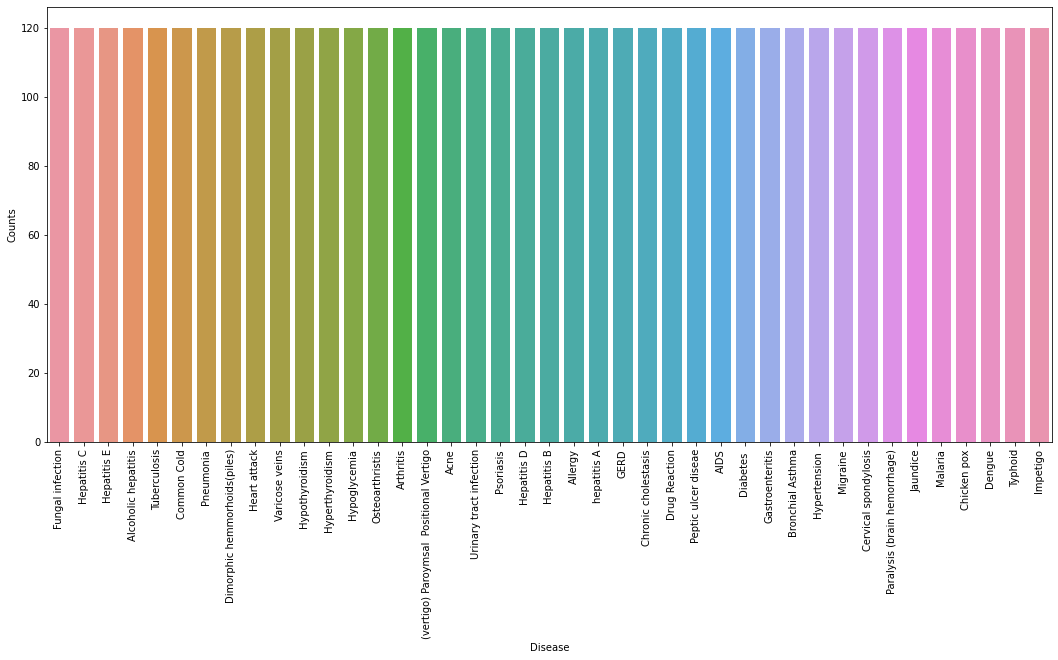

In [2]:
DATA_PATH = "data/training_data.csv"
data = pd.read_csv(DATA_PATH).dropna(axis = 1)
corr=data.corr()
# Checking whether the dataset is balanced or not
disease_counts = data["prognosis"].value_counts()
temp_df = pd.DataFrame({
    "Disease": disease_counts.index,
    "Counts": disease_counts.values
})
 
plt.figure(figsize = (18,8))
sns.barplot(x = "Disease", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()

In [3]:
encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])

In [4]:
X = data.iloc[:,:-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test =train_test_split(
  X, y, test_size = 0.2, random_state = 24)
 
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (3936, 132), (3936,)
Test: (984, 132), (984,)


<AxesSubplot:>

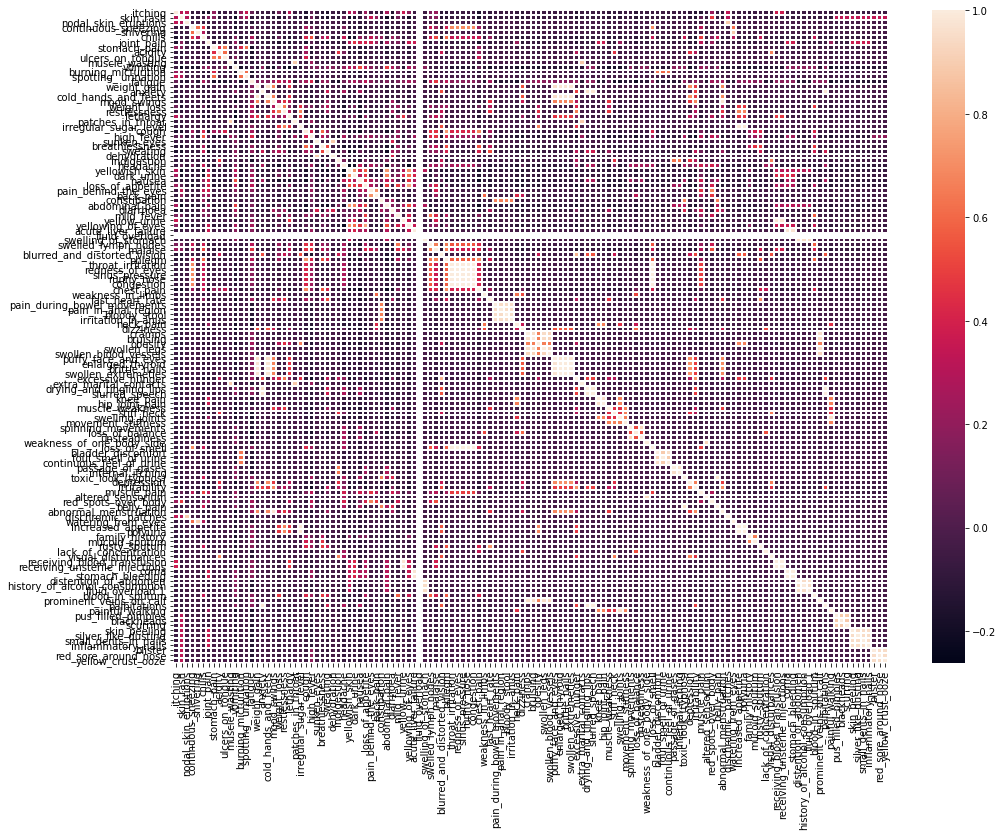

In [5]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidth="2", ax=ax)
#sns.pairplot(data)

Accuracy on train data by Naive Bayes Classifier: 100.0
Accuracy on test data by Naive Bayes Classifier: 100.0


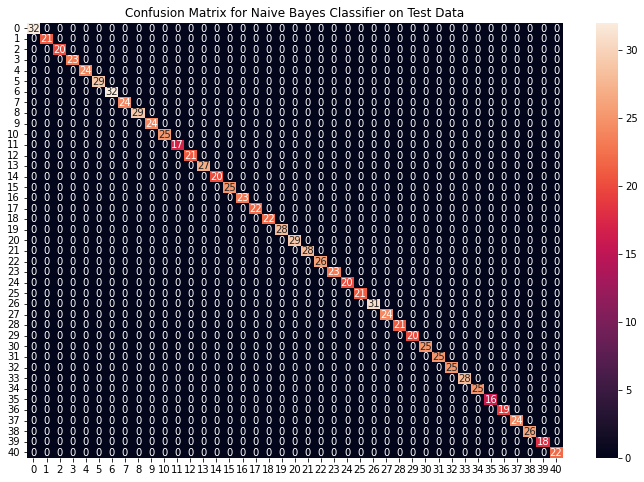

Accuracy on train data by Random Forest Classifier: 100.0
Accuracy on test data by Random Forest Classifier: 100.0


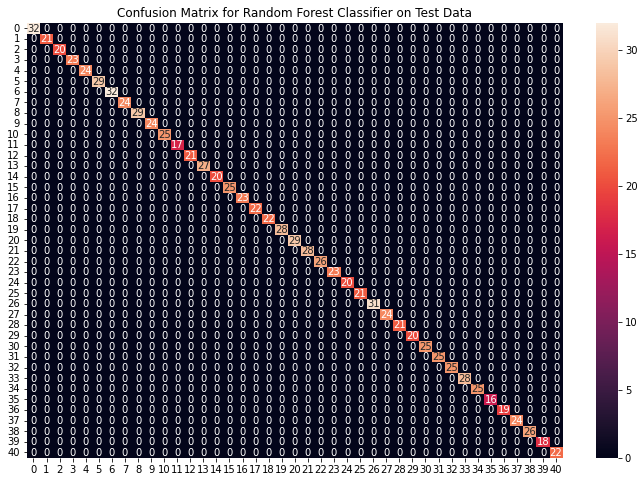

Accuracy on train data by GradientBoostingClassifier: 100.0
Accuracy on test data by GradientBoostingClassifier: 100.0


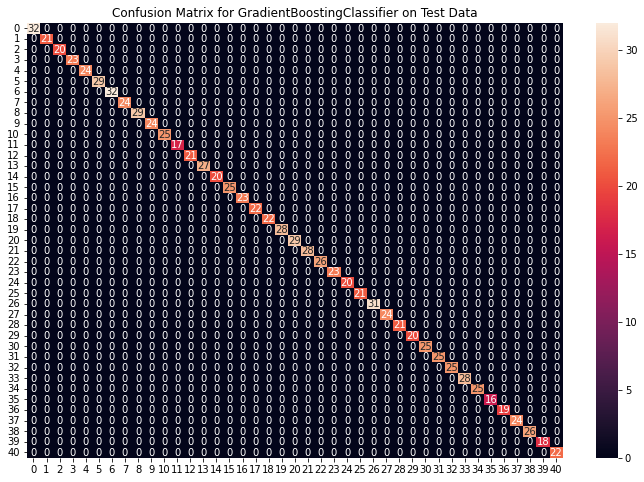

In [6]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
preds = nb_model.predict(X_test)
print(f"Accuracy on train data by Naive Bayes Classifier\
: {accuracy_score(y_train, nb_model.predict(X_train))*100}")
 
print(f"Accuracy on test data by Naive Bayes Classifier\
: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Naive Bayes Classifier on Test Data")
plt.show()

rf_model = RandomForestClassifier(random_state=18)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
print(f"Accuracy on train data by Random Forest Classifier\
: {accuracy_score(y_train, rf_model.predict(X_train))*100}")
 
print(f"Accuracy on test data by Random Forest Classifier\
: {accuracy_score(y_test, preds)*100}")
 
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
plt.show()

gbc_model = GradientBoostingClassifier(random_state=18)
gbc_model.fit(X_train, y_train)
preds = gbc_model.predict(X_test)
print(f"Accuracy on train data by GradientBoostingClassifier\
: {accuracy_score(y_train, gbc_model.predict(X_train))*100}")
 
print(f"Accuracy on test data by GradientBoostingClassifier\
: {accuracy_score(y_test, preds)*100}")
 
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for GradientBoostingClassifier on Test Data")
plt.show()

Accuracy on Test dataset by the combined model: 100.0


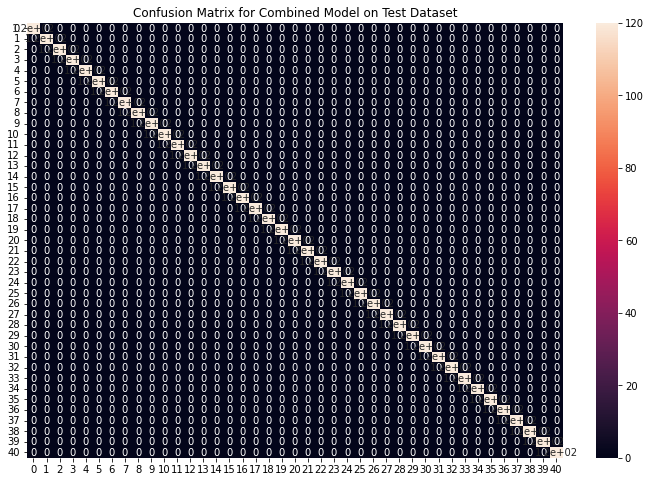

In [7]:
final_svm_model = SVC()
final_nb_model = MultinomialNB()
final_rf_model = RandomForestClassifier(random_state=18)
final_svm_model.fit(X, y)
final_nb_model.fit(X, y)
final_rf_model.fit(X, y)
 
# Reading the test data
test_data = pd.read_csv("./data/training_data.csv").dropna(axis=1)
 
test_X = test_data.iloc[:, :-1]
test_Y = encoder.transform(test_data.iloc[:, -1])
 
# Making prediction by take mode of predictions
# made by all the classifiers
svm_preds = final_svm_model.predict(test_X)
nb_preds = final_nb_model.predict(test_X)
rf_preds = final_rf_model.predict(test_X)
 
final_preds = [mode([i,j,k])[0][0] for i,j,
               k in zip(svm_preds, nb_preds, rf_preds)]
 
print(f"Accuracy on Test dataset by the combined model\
: {accuracy_score(test_Y, final_preds)*100}")
 
cf_matrix = confusion_matrix(test_Y, final_preds)
plt.figure(figsize=(12,8))
 
sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for Combined Model on Test Dataset")
plt.show()

In [8]:
symptoms = X.columns.values
 
# Creating a symptom index dictionary to encode the
# input symptoms into numerical form
symptom_index = {}
for index, value in enumerate(symptoms):
    symptom = " ".join([i.capitalize() for i in value.split("_")])
    symptom_index[symptom] = index
 
data_dict = {
    "symptom_index":symptom_index,
    "predictions_classes":encoder.classes_
}
 
# Defining the Function
# Input: string containing symptoms separated by commmas
# Output: Generated predictions by models
def predictDisease(symptoms):
    symptoms = symptoms.split(",")
     
    # creating input data for the models
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"][symptom]
        input_data[index] = 1
         
    # reshaping the input data and converting it
    # into suitable format for model predictions
    input_data = np.array(input_data).reshape(1,-1)
     
    # generating individual outputs
    rf_prediction = data_dict["predictions_classes"][final_rf_model.predict(input_data)[0]]
    nb_prediction = data_dict["predictions_classes"][final_nb_model.predict(input_data)[0]]
    svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]]
     
    # making final prediction by taking mode of all predictions
    final_prediction = mode([rf_prediction, nb_prediction, svm_prediction])[0][0]
    predictions = {
        "rf_model_prediction": rf_prediction,
        "naive_bayes_prediction": nb_prediction,
        "svm_model_prediction": nb_prediction,
        "final_prediction":final_prediction
    }
    return predictions
 
# Testing the function
print(predictDisease("Itching,Skin Rash,Nodal Skin Eruptions"))

{'rf_model_prediction': 'Fungal infection', 'naive_bayes_prediction': 'Fungal infection', 'svm_model_prediction': 'Fungal infection', 'final_prediction': 'Fungal infection'}


c:\Users\rajaa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\rajaa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(
c:\Users\rajaa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
